In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
import math
from tqdm import tqdm

pd.options.mode.chained_assignment = None

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["animation.embed_limit"] = 500

In [52]:
df = pd.read_csv("./output/resampling_upscale_0.0833333mins_20len_FORMATED.csv",delimiter="\t", names=["time","traj_id","x","y"])

In [53]:
df.head()

,time,traj_id,x,y
0,0,1,8.560,10.440
1,1,1,7.510,10.505
2,2,1,6.460,10.570
3,3,1,5.790,10.560
4,4,1,4.865,10.545


In [54]:
bg_store_img_metadata = {'path':"./data/german_1/storePlan_fix.jpg",'image_crop':[0, 45.6, 0, 26.7], "x_lim": (-1, 44.56), "y_lim" : (26.40, -1) }
def putBgStoreImage(ax, plotFunc = None):
    bg_img = mpimg.imread(bg_store_img_metadata["path"])
    
    ax.xaxis.tick_top()

    ax.imshow(bg_img, extent=bg_store_img_metadata["image_crop"], origin="lower", aspect="equal")

    ax.set_xlim(bg_store_img_metadata["x_lim"])
    ax.set_ylim(bg_store_img_metadata["y_lim"])

In [55]:
def getTrajectory(traj_data):
    traj_data = traj_data.sort_values(by="time")
    
    fig,ax = plt.subplots(figsize=(12,6))
    putBgStoreImage(ax)
    
    start = traj_data.iloc[0]
    end = traj_data.iloc[-1]

    


    square, = ax.plot(traj_data.x, traj_data.y, color = 'blue', marker = 's', markersize=3 )
    ax.plot(traj_data['x'], traj_data['y'], color = 'black',  markersize=0.5) 
   
    

    circle_start = plt.Circle((start["x"],start["y"]), 0.5, color="green")
    circle_end = plt.Circle((end["x"],end["y"]), 0.5, color="yellow")
    
    ax.add_patch(circle_start)
    ax.add_patch(circle_end)
    
    ax.set_title(f'Trajectory for tag {traj_data.traj_id.iloc[0]}')
    plt.show()

In [56]:
def trajectoryAnimation(traj_data):
    traj_data = traj_data.sort_values(by="time")
    
    fig, ax = plt.subplots(figsize=(12,6))
    putBgStoreImage(ax)
     
    square, = ax.plot(traj_data.x.iloc[0], traj_data.y.iloc[0], color = 'blue', marker = 's', markersize=2 )
    line, = ax.plot(traj_data.x.iloc[0:1], traj_data.y.iloc[0:1], color = 'grey' )
    dot, = ax.plot(traj_data.x.iloc[0], traj_data.y.iloc[0], color = 'black', marker = 'o' )

    def update_frame(t):
        square.set_data([traj_data.x.iloc[0:t+1]], [traj_data.y.iloc[0:t+1]])
        line.set_data([traj_data.x.iloc[0:t+1]], [traj_data.y.iloc[0:t+1]])
        dot.set_data([traj_data.x.iloc[t]], [traj_data.y.iloc[t]])
        ax.set_title(f'Relationship between x and y at step {t}', fontsize=14)
        return square, line, dot
    
    time = np.arange(len(traj_data.x))
    anim = animation.FuncAnimation(fig, update_frame, frames=time, interval=100)
    
    anim.save(f'./output/Gifs/{traj_data.traj_id.iloc[0]}_{traj_data.traj_id.iloc[0]}.gif', writer='pillow')
    return anim

In [57]:
#trajectoryAnimation(df[df.traj_id == 1])

*Data Filtering and Smoothing*

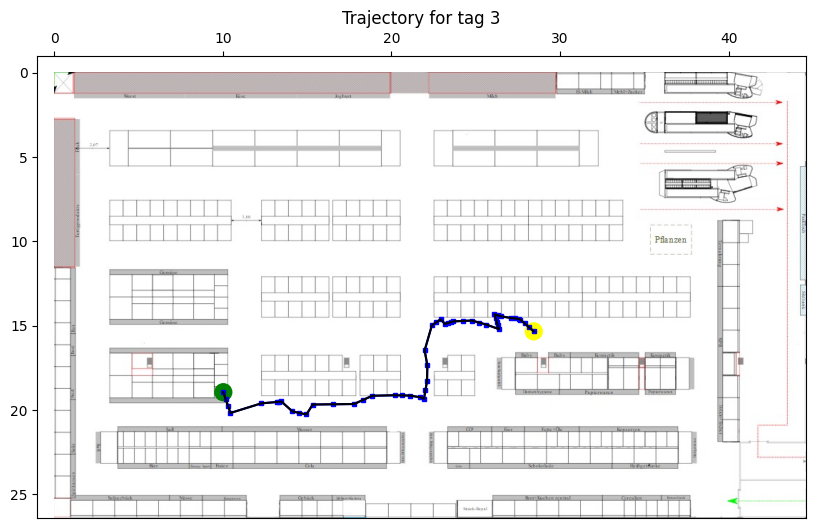

In [58]:
getTrajectory(df[df.traj_id == 3])

***Convolution Filter***

In [63]:
def smoothTraj(traj, filters):
    for _filter  in filters:
        x = np.correlate(traj.x, _filter, mode="valid")
        y = np.correlate(traj.y, _filter, mode="valid")
        pad = math.floor(len(_filter)/2)
        traj.iloc[pad:-pad,2] = x
        traj.iloc[pad:-pad,3] = y

        traj_len = len(traj.x)
        for idx in range(traj_len-pad-2, traj_len-1):
            if idx < len(traj.x)-1:
                traj.y.iloc[idx] = (traj.y.iloc[idx-1] + traj.y.iloc[idx] + traj.y.iloc[idx+1])/3
                traj.x.iloc[idx] = (traj.x.iloc[idx-1] + traj.x.iloc[idx] + traj.x.iloc[idx+1])/3
            else:
                traj.y.iloc[idx] = (traj.y.iloc[idx-1] + traj.y.iloc[idx])/2
                traj.x.iloc[idx] = (traj.x.iloc[idx-1] + traj.x.iloc[idx])/2

        for idx in range(0, pad):
            if idx != 0:
                traj.x.iloc[idx] = (traj.x.iloc[idx-1] + traj.x.iloc[idx] + traj.x.iloc[idx+1])/3
                traj.y.iloc[idx] = (traj.y.iloc[idx-1] + traj.y.iloc[idx] + traj.y.iloc[idx+1])/3
            else:
                traj.x.iloc[idx] = (traj.x.iloc[idx] + traj.x.iloc[idx+1])/2
                traj.y.iloc[idx] = (traj.y.iloc[idx] + traj.y.iloc[idx+1])/2

        return traj



In [74]:
data = pd.DataFrame(columns=df.columns)
filters = [[0.25,0.25,0,0.25,0.25],[0.1,0.1,0.6,0.1,0.1],[0.1,0.8,0.1]] #weighted average filter

ids = df.traj_id.unique()

for id in tqdm(ids):
    new_data = smoothTraj(df[df.traj_id == id ],filters)
    data = pd.concat([data, new_data],ignore_index=True)

100%|██████████| 16560/16560 [05:48<00:00, 47.47it/s]


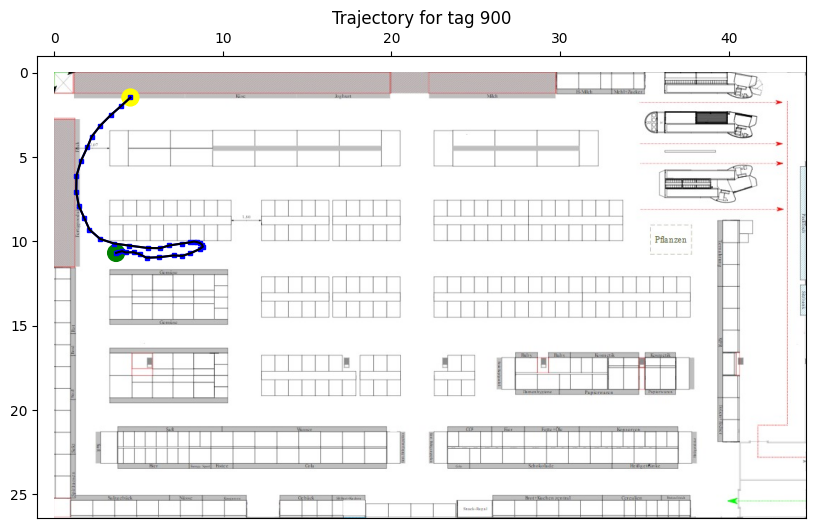

In [84]:
getTrajectory(data[data.traj_id == 900])

In [86]:
data.sort_values(by="time", inplace=True)
data.to_csv("output/German1/DATA_SMOOTH_TRAJECTORIES",index=False, header=False)